In [3]:
import numpy as np
from hmmlearn.hmm import GaussianHMM
import pandas_datareader as pdr
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import itertools

In [8]:
df = yf.download("^NSEI", start="2018-05-29", end="2018-12-07")
df.to_csv('^NSEI.csv')
df.shape[0]

[*********************100%***********************]  1 of 1 completed


130

[10224.75, 10124.900390625, 10030.0, 10250.849609375, 10198.400390625, 10386.599609375, 10380.4501953125, 10553.0, 10524.0, 10530.0, 10598.400390625, 10585.2001953125, 10482.2001953125, 10582.5, 10576.2998046875, 10616.7001953125, 10682.2001953125, 10763.400390625, 10656.2001953125, 10600.0498046875, 10526.75, 10628.599609375, 10685.599609375, 10728.849609375, 10858.7001953125, 10876.75, 10883.75, 10869.5, 10782.900390625, 10601.150390625]
[10278.150390625, 10135.0498046875, 10122.349609375, 10078.099609375, 10239.400390625, 10209.5498046875, 10441.7001953125, 10462.2998046875, 10558.75, 10552.0, 10614.4501953125, 10614.7001953125, 10607.7998046875, 10451.900390625, 10634.900390625, 10580.599609375, 10644.0, 10731.25, 10740.099609375, 10670.9501953125, 10612.650390625, 10568.2998046875, 10621.4501953125, 10708.75, 10808.7001953125, 10892.099609375, 10930.7001953125, 10877.099609375, 10820.4501953125, 10718.150390625]


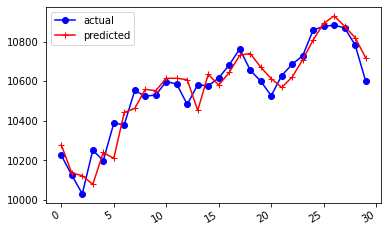

In [26]:
class HMM_Prediction:
    
    def __init__(self, hidden_states=4, latency=14, train_size=100):
        self.latency = latency
        self.hmm = GaussianHMM(n_components=hidden_states)
        self.data = pd.read_csv('^NSEI.csv')
        self.train_data = self.get_fractions(self.data[:train_size])
        self.test_data = self.get_fractions(self.data[train_size:])
        self.test_open_prices = self.data['Open'][train_size:]
        self.test_close_prices = self.data['Close'][train_size:]
        self.possible_observations = self.get_possible_observations()
        
    def get_fractions(self, df):
        np_open = np.array(list(df['Open']))
        np_close = np.array(list(df['Close']))
        np_high = np.array(list(df['High']))
        np_low = np.array(list(df['Low']))
        fr_close = (np_close-np_open)/np_open
        fr_high = (np_high-np_open)/np_open
        fr_low = (np_open-np_low)/np_open
        return np.column_stack((fr_close, fr_high, fr_low))
    
    def get_possible_observations(self, close_steps=21, high_steps=11, low_steps=11):
        close_fractions = np.linspace(-0.1, 0.1, close_steps)
        high_fractions = np.linspace(0, 0.1, high_steps)
        low_fractions = np.linspace(0, 0.1, low_steps)
        possible_observations = np.array(list(itertools.product(close_fractions, high_fractions, low_fractions)))
        return possible_observations
    
    def predict_close_value(self, index):
        if index >= self.latency:
            min_index = index-self.latency
        else:
            min_index = 0
        max_index = (index-1) if index > 0 else 0
        past_observations = self.test_data[min_index : max_index]
        scores = []
        for observation in self.possible_observations:
            observation_sequence = np.row_stack((past_observations, observation))
            scores.append(self.hmm.score(observation_sequence))
        most_probable_observation = self.possible_observations[np.argmax(scores)][0]
        open_value = list(self.test_open_prices)[index]
        return open_value*(1 + most_probable_observation)
    
    def test_predictions(self):
        predicted_closing_prices = []
        for index in range(len(self.test_data)):
            predicted_closing_prices.append(self.predict_close_value(index))
            
        real_close_prices = list(self.test_close_prices)

        fig = plt.figure()

        axes = fig.add_subplot(111)
        indices = list(range(len(real_close_prices)))
        axes.plot(indices, real_close_prices, 'bo-', label="actual")
        axes.plot(indices, predicted_closing_prices, 'r+-', label="predicted")

        fig.autofmt_xdate()
        print(real_close_prices)
        print(predicted_closing_prices)
        plt.legend()
        plt.show() 
        

hmm_stocks = HMM_Prediction()
hmm_stocks.hmm.fit(hmm_stocks.train_data)
hmm_stocks.test_predictions()

        
    
    
        
        
        
        
        
        